Model usage and sampling
========================

In this notebook, we demonstrate the API of the `qmmc` module by first generating a fake RFQs dataset from Gaussian distributions for both the clients and traders. We then save the generated dataset keeping only variables that are observed by one of the seller and finally try to recover the parameters for clients as well as competitors.

In [2]:
import os, time
%pylab inline

NUM_COLORS = 5

cm = get_cmap('gist_rainbow')
color = []
for i in range(NUM_COLORS):
    color.append(cm(1.*i/NUM_COLORS))

Populating the interactive namespace from numpy and matplotlib


Simulate and save a dataset
---------------------------

In [3]:
from qmmc.market import GaussianQuoteMarket

In this examples we chose to use a `GaussianQuoteMarket` for simplicity (it is faster to sample from). However, either `EPQuoteMarket` or `SEPQuoteMarket` could have been used instead.

We also chose to add 3 covariates to the model that will influence the way participants value a particular bond. Those covariates could be numeric or categorical variables but in the generated dataset they are simply random variables sampled from a normal distribution: $z_i \sim \mathcal{N}(1, 1)$ for $i \in \{1, 2, 3\}$

In [4]:
alpha_real=(0, 2)
beta_real=[(1, 2), (-1, 2)]
market = GaussianQuoteMarket(alpha_real, beta_real, nb_covar=3)

In [5]:
# Manually assign weights for regression
add_covariables = True
if add_covariables == True:
    alpha_covweights = [-1, 0, 1]
    beta_covweights = [1,0, -1]
    market.set_covar_weights(alpha_covweights, beta_covweights)

In [6]:
market.simulate("Buy", 5000)

We the simulation of RFQs has finished we simply save the observed variables in a `csv` file.

In [7]:
savedir = '../data/exp/%s/' % time.strftime("%c") 
if not os.path.exists(savedir):
    os.makedirs(savedir)

market.save(savedir)

Loading the data
----------------

We now have a dataset that is roughly equivqlent to what a bank would observed when an RFQ is treated. In reality, the covariates would be attributes of the quote like its rating for example.

In [8]:
import pandas as pd
df = pd.read_csv(savedir + 'fake-market.csv')

In [9]:
df.head()

,TradeStatus,StatusDetails,BNPPAnsweredQuote,CoverPrice,RFQCompositePrice,Bid2Mid,Customer,NbDealers,delta,BuySell,z0,z1,z2
0,NotTraded,None,109.825974,0,110,0.5,2,5,-0.348053,Buy,0.246861,0.853418,0.586225
1,NotTraded,None,109.628311,0,110,0.5,2,3,-0.743378,Buy,1.410421,1.979208,2.261004
2,Done,None,108.434685,0,110,0.5,1,2,-3.130630,Buy,1.348663,1.000680,0.915400
3,Done,None,109.478371,0,110,0.5,1,4,-1.043259,Buy,0.222801,1.235106,-0.473886
4,Done,None,107.950218,0,110,0.5,2,5,-4.099564,Buy,1.863025,2.007556,-0.519607


Training the model
------------------

Recovering the market parameters is then done by loading back the observed variables into a new model 
(here we chose to use a `GaussianQuoteMarket` again to be able to compare the learned parameters with the real ones). 
We also specify which columns of the `csv` file will serve as covariates and whether they are `numerical` or `categorical` 
variables.

In [10]:
# Reload the saved market
covar = {'z0': {'type': "num"}, 'z1': {'type': "num"}, 'z2': {'type': "num"}}
market = GaussianQuoteMarket.load(savedir + "fake-market.csv", covar=covar)

If we want to specify a reasonable set of initial parameters to start the Gibbs sampling from we can do so by 
manually setting the parameters to our desired values.

In [11]:
market.sample(1000, sample_covar=True)

Finally, after 1000 iterations of the Gibbs sampler we can have a look at the current state of the model.

In [12]:
print "Number of samples: %d" % market.sampler.iteration
print market

Number of samples: 1000
Y ~ Alpha: mu = 0.06, sigma = 2.08, nb_quotes = 5000,
W ~ Alpha: mu = 0.06, sigma = 2.08, nb_quotes = 5000, 
V ~ Beta_1: mu = 1.19, sigma = 1.80, id = 1, nb_quotes = 2509
    Beta_2: mu = -0.72, sigma = 2.14, id = 2, nb_quotes = 2491


### Plotting

To better visualize the result of the learning procedure, we can plot the "random walk" of samples along iterations
as well as the influence on the log-likelihood of the latent variables.

In [13]:
from qmmc.utils import plot_market_hist

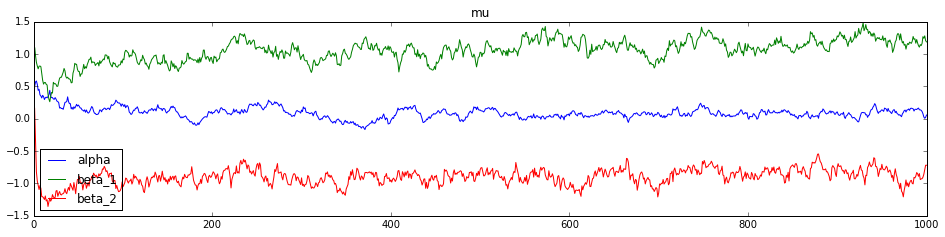

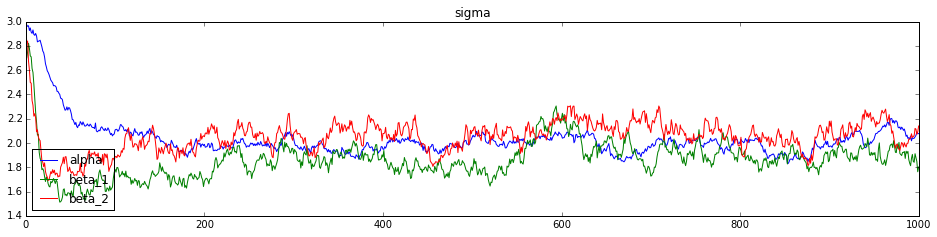

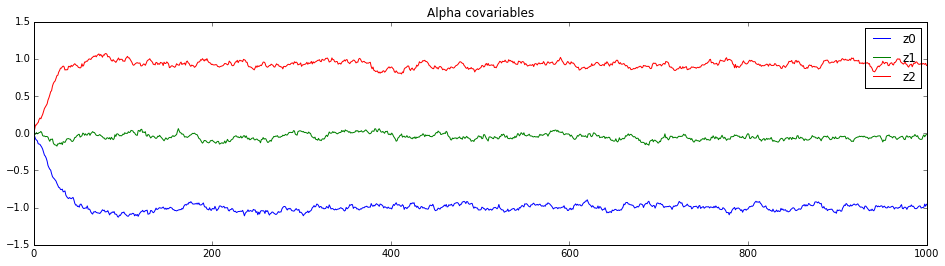

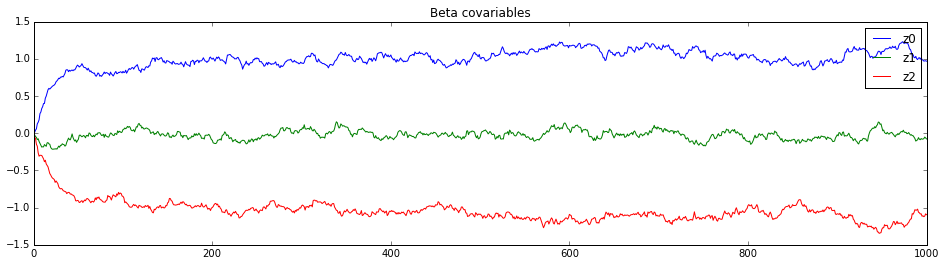

In [14]:
plot_market_hist(market)

We can also compare visually the parameters as learned by the Gibbs sampling procedure to the real parameters
from which we generated the data. To do so we first set the value of the learned parameters to their average, discarding the first 500 samples.

In [19]:
from qmmc.utils import set_mean_params

set_mean_params(market, burn_in=200)
print market

Y ~ Alpha: mu = 0.08, sigma = 1.99, nb_quotes = 5000,
W ~ Alpha: mu = 0.08, sigma = 1.99, nb_quotes = 5000, 
V ~ Beta_1: mu = 1.11, sigma = 1.89, id = 1, nb_quotes = 2509
    Beta_2: mu = -0.88, sigma = 2.08, id = 2, nb_quotes = 2491


Let's also check that the average parameters also correspond roughly to the mode of the posterior.

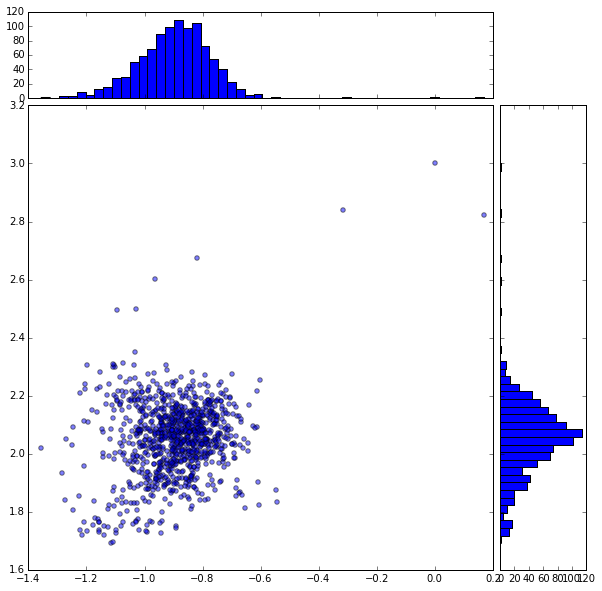

In [20]:
from qmmc.utils import gaussian_market_scatter_hist

p = "beta_2"
gaussian_market_scatter_hist(market, param=p)

Now we look at the recovered parameters (plain lines) compared to the real values (dashed lines).

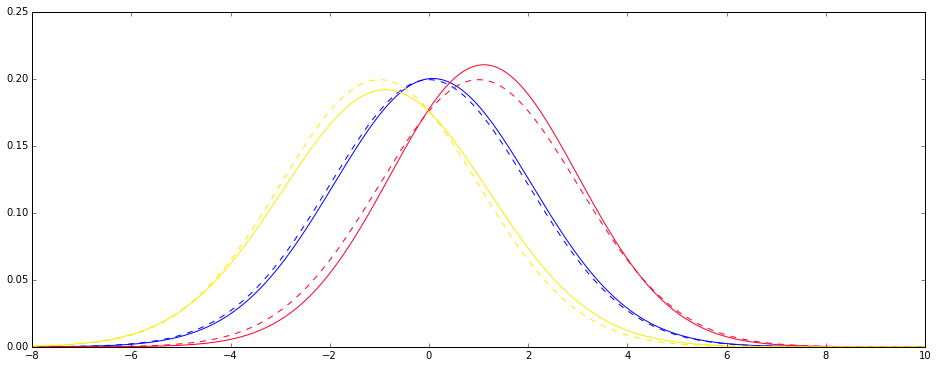

In [21]:

from qmmc.distrib import *
x = np.linspace(-8, 10, 500)

plt.figure(figsize=(16, 6))
alpha, beta = market.get_params()
plt.plot(x, scipy.stats.norm.pdf(x, alpha.mu, alpha.sigma), 'b', )
plt.plot(x, scipy.stats.norm.pdf(x, *alpha_real), 'b--')

for i, b in enumerate(beta.itervalues()):
    plt.plot(x, scipy.stats.norm.pdf(x, b.mu, b.sigma), color=color[i])
    plt.plot(x, scipy.stats.norm.pdf(x, *beta_real[i]), '--', color=color[i])

plt.show()

Performance of the learned model
--------------------------------

First we can look at the log-likelihood obtain on the quotes.

In [22]:
market.loglik(n_iter=100)

-3310.0474042024853

Looking at the predictive performance of the model is also interesting. Here we look at the predictive performace on the set of 
quotes that were used during training (sampling).  Using a different test set would be preferable.

In [23]:
predictions = market.predict(market.quotes, type='labels')

In [24]:
real_labels = np.array([quote.I for quote in market.quotes])
predicted_labels = np.array(predictions)
print "Accuracy = %.2f%%" % (100 * (float(sum(real_labels == predicted_labels)) / len(predictions)))

Accuracy = 72.04%
